In [84]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from collections import defaultdict
import pandas as pd
from pathlib import Path
import zipfile
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/manuel/anaconda3/envs/machinelearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import data and prepare datasets and dataloaders

In [2]:
# Extract zip file for first time
zip_path = Path("Bird dataset/archive.zip")
data_path = Path("Bird dataset/")
if zip_path.exists():
    print("Extract zip file")
    with zipfile.ZipFile(zip_path) as file:
        file.extractall(data_path)
    # Remove zip file
    Path.unlink(zip_path)
else:
    print("Already extracted")

Already extracted


In [3]:
# Create transformers to convert images into tensors
data_transformer = transforms.Compose([
    # Resize images to 150 x 150
    transforms.Resize(size=(150, 150)),
    # Augment data by flipping
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    # Transform images into tensors and automatically scale them
    transforms.ToTensor()    
])

In [4]:
# Create paths to folders
train_dir = data_path.joinpath("train")
test_dir = data_path.joinpath("test")
val_dir = data_path.joinpath("valid")

# Create datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transformer)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transformer)
val_data = datasets.ImageFolder(root=val_dir, transform=data_transformer)

print(train_data)

Dataset ImageFolder
    Number of datapoints: 84635
    Root location: Bird dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [5]:
# Inspect classes
class_names = train_data.classes
print(class_names)
print(f"Number of classes: {len(class_names)}")

['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'ASIAN GREEN BEE EATER', 'ASIAN OPENBILL STORK', 'AUCKLAND SHAQ', 'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT', 'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'AZURE JAY', 'AZURE TANAGER', '

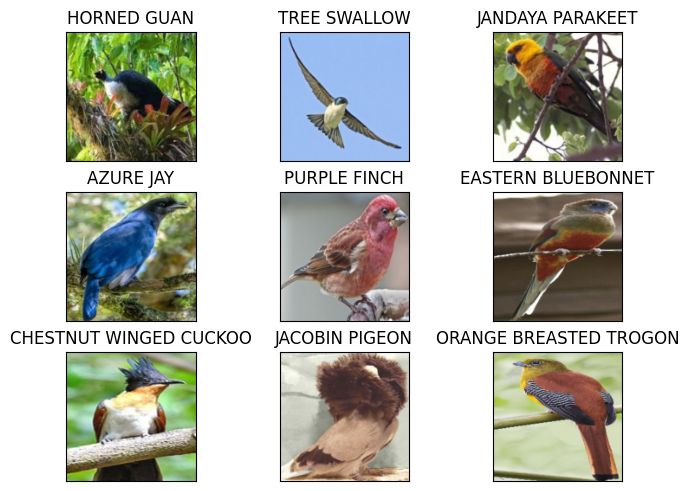

In [6]:
# Inspect 9 random images
import random
fig, ax = plt.subplots(3,3, layout="constrained")
ax = ax.flatten()
for i in range(9):
    rnd_pick = random.choice(train_data)
    img, label = rnd_pick[0], rnd_pick[1]
    ax[i].imshow(img.permute(1,2,0))
    ax[i].set_title(class_names[label])
    ax[i].set_xticklabels("")
    ax[i].set_yticklabels("")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

In [ ]:
len(train_data)

In [7]:
# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False
)
val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False
)

# Model 0 (Baseline)

Dummy classifier that always predicts the most frequent class.

In [75]:
# Initialize a defaultdict to store class counts
class_counts = defaultdict(int)

# Iterate through the dataset and count the occurrences of each class
for _, label in train_data:
    class_counts[label] += 1
# Turn into dataframe
class_count_df = pd.DataFrame({"counts": class_counts.values()}, index=class_names)
# Check counts of most abundant and least abundant class
class_count_df.sort_values(by="counts")

,counts
EURASIAN GOLDEN ORIOLE,130
RED TAILED THRUSH,130
SNOWY PLOVER,130
AMETHYST WOODSTAR,130
PATAGONIAN SIERRA FINCH,130
...,...
ASIAN GREEN BEE EATER,220
D-ARNAUDS BARBET,233
OVENBIRD,233
HOUSE FINCH,248


In [76]:
# Determine frequencies of extreme classes
mininum_class = class_count_df.min()
maximum_class = class_count_df.max()
sum_classes = class_count_df.sum()
frequency_low = 100 * (mininum_class / sum_classes)
frequency_high = 100 * (maximum_class / sum_classes)
print(f"Lowest frequency: {frequency_low.item()} \nHighest frequency: {frequency_high.item()}")

Lowest frequency: counts    0.153601
dtype: float64 
Highest frequency: counts    0.310746
dtype: float64


**A dummy classifier will achive 0.3% accuracy**

# Model 1 (Basic CNN)

In [90]:
# Define accuracy function
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    """
    Calculates the accuracy of predicted labels compared to true labels.

    Args:
        y_true (torch.Tensor): Tensor containing correct labels.
        y_pred (torch.Tensor): Tensor containing predicted labels.

    Returns:
        float: The accuracy as a percentage.
            Accuracy is computed as the ratio of correctly predicted labels to the total number of labels.
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = 100 * correct / len(y_pred)
    return acc
# Define functions for training and evaluation
def train_step(
    model: torch.nn.Module,
    data: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn: callable,
    device: torch.device = device
)-> None:
    """
    Performs a single training step on the provided model using the given data.

    Args:
        model (torch.nn.Module): The PyTorch model to be trained.
        data_loader (torch.utils.data.DataLoader): DataLoader providing batches of training data.
        loss_fn (torch.nn.Module): The loss function used for optimization.
        optimizer (torch.optim.Optimizer): The optimizer for updating the model's parameters.
        accuracy_fn (callable): A function to calculate the accuracy of model predictions.
        device (torch.device): The device where the model and data should be moved. Defaults to `device`.

    Returns:
        None
    """   
    # Initialize loss and accuracy
    train_loss, train_accuracy = 0, 0
    # Send model to device
    model.to(device)
    
    # Iterate over batches
    for batch, (images, labels) in enumerate(data):
        # Send data to device
        images, labels = images.to(device), labels.to(device)
        # Send images trough forward path
        labels_pred = model(images)
        # Calculate loss
        loss = loss_fn(labels_pred, labels)
        # Add loss of current batch to overall loss
        train_loss += loss
        # Add accuracy to overall accuracy
        train_accuracy = accuracy_fn(
            y_true=labels,
            y_pred=labels_pred.argmax(dim=-1))
        # Calculate gradient and adjust weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate loss and accuracy per epoch
    train_loss /= len(data)
    train_acc /= len(data)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def val_step(
    data: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn: callable,
    device: torch.device = device) -> None:
    """
    Performs a validation step on the provided model using the given validation data.

    Args:
        data_loader (torch.utils.data.DataLoader): DataLoader providing batches of validation data.
        model (torch.nn.Module): The PyTorch model to be validated.
        loss_fn (torch.nn.Module): The loss function used for evaluation.
        accuracy_fn (callable): A function to calculate the accuracy of model predictions.
        device (torch.device): The device where the model and data should be moved. Defaults to `device`.

    Returns:
        None
    """   
    # Initialize loss and accuracy
    val_loss, val_accuracy = 0, 0
    # Send model to device
    model.to(device)
    model.eval() 
    # Turn on inference context manager
    with torch.inference_mode():
        # Iterate trough batches
        for images, labels in data:
            # Send data to GPU
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            val_pred = model(images)
            
            # Calculate loss and accuracy
            val_loss += loss_fn(val_pred, labels)
            val_accuracy += accuracy_fn(
                y_true=labels,
                y_pred=val_pred.argmax(dim=1))
        
        # Adjust metrics and print out
        val_loss /= len(data)
        val_accuracy /= len(data)
        print(f"Val loss: {val_loss:.5f} | Val accuracy: {val_accuracy:.2f}%\n")

In [93]:
# Create mmodel class
class Model1(nn.Module):
    def __init__(self, input_shape:int, hidden_units: int, output_shape: int):
        super().__init__()
        
        self.cnn_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=5,
                      stride=1,
                      padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        
        self.cnn_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
        
    def forward(self, input: torch.Tensor):
        x = self.cnn_block1(input)
        x = self.cnn_block2(x)
        logits = self.classifier(x)
        return logits

# Create model
model_1 = Model1(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
    ).to(device)

model_1

Model1(
  (cnn_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=525, bias=True)
  )
)

In [94]:
# Train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.01)

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(
        data=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
    val_step(
        data=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
